# ResNet50


In [1]:
# Upgrade and install dependencies
!pip install --upgrade pip
!pip install pandas
!pip install sklearn
!pip install seaborn

In [2]:
# Import Libraries
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adamax
from sklearn.metrics import confusion_matrix

In [3]:
# Set memory growth and list GPU
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print("TensorFlow version: ", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPU name: ", tf.test.gpu_device_name())

TensorFlow version:  2.8.0
Num GPUs Available:  1
GPU name:  /device:GPU:0


# Preparation of the data set


In [4]:
# Set image_dataset_from_directory parameters
DIRECTORY = "datasets/Split_0-Binary"
LABELS = "inferred"
LABEL_MODE = "int"
COLOR_MODE = "rgb"
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
SHUFFLE = True
SEED = 1777
VALIDATION_SPLIT = 0.2
CROP_TO_ASPECT_RATIO = True

# Create training set
train_ds = keras.preprocessing.image_dataset_from_directory(
    directory = DIRECTORY,
    labels = LABELS, 
    label_mode = LABEL_MODE,
    color_mode = COLOR_MODE,
    batch_size = BATCH_SIZE,
    image_size = IMAGE_SIZE,
    shuffle = SHUFFLE,
    seed = SEED,
    validation_split = VALIDATION_SPLIT, 
    subset = "training",    
    crop_to_aspect_ratio = CROP_TO_ASPECT_RATIO
)
# Create validation set
val_ds = keras.preprocessing.image_dataset_from_directory(
    directory = DIRECTORY,
    labels = LABELS, 
    label_mode = LABEL_MODE,
    color_mode = COLOR_MODE,
    batch_size = BATCH_SIZE,
    image_size = IMAGE_SIZE,
    shuffle = SHUFFLE,
    seed = SEED,
    validation_split = VALIDATION_SPLIT, 
    subset = "validation",    
    crop_to_aspect_ratio = CROP_TO_ASPECT_RATIO
)

Found 23061 files belonging to 2 classes.
Using 18449 files for training.
Found 23061 files belonging to 2 classes.
Using 4612 files for validation.


In [5]:
# Create test set
test_ds = keras.preprocessing.image_dataset_from_directory(
    directory = "datasets/Split_1-Binary",
    labels = LABELS, 
    label_mode = LABEL_MODE,
    color_mode = COLOR_MODE,
    batch_size = BATCH_SIZE,
    image_size = IMAGE_SIZE,
    shuffle = SHUFFLE,
    seed = SEED,   
    validation_split = None, 
    subset = None,   
    crop_to_aspect_ratio = CROP_TO_ASPECT_RATIO
)

Found 24092 files belonging to 2 classes.


In [6]:
# Optimizing
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Explore dataset

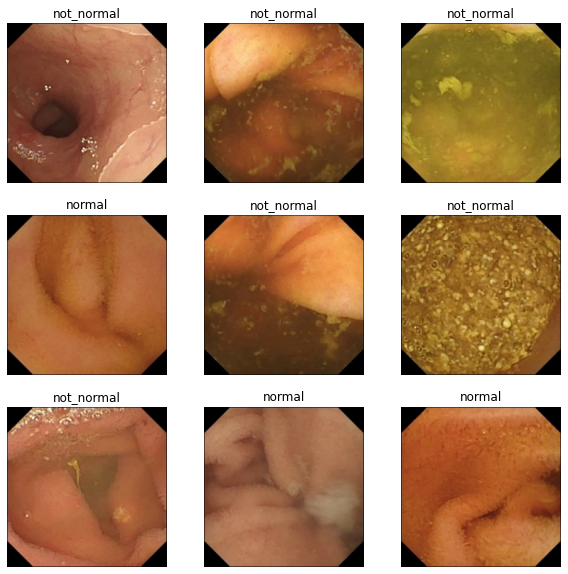

In [7]:
class_names = ["normal", "not_normal"]
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
def plot_cm(cf_matrix):
    
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    ax.set_title('Seaborn Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()

# Creating and training the model

In [9]:
# Import base model and freeze layers
base_model = tf.keras.applications.resnet50.ResNet50(weights = 'imagenet', include_top = False, input_shape = (224,224,3))
for layer in base_model.layers:
    layer.trainable = False

94781440/94765736 [==============================] - 8s 0us/step


In [10]:
# Print model summary
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [11]:
# Creating dictionary that maps layer names to the layers
layer_dict = dict([(layer.name, layer) for layer in base_model.layers])
# Getting output tensor of the last layer that we want to include
x = layer_dict['conv5_block3_out'].output

In [12]:
# Add custom layers
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.25)(x) 
predictions = Dense(1, activation = None)(x)
model = tf.keras.Model(inputs = base_model.input, outputs = predictions)

In [13]:
# Print custom model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [14]:
# Confirm which layers that are trainable
for l in model.layers:
    print(l.name, l.trainable)

input_1 False
conv1_pad False
conv1_conv False
conv1_bn False
conv1_relu False
pool1_pad False
pool1_pool False
conv2_block1_1_conv False
conv2_block1_1_bn False
conv2_block1_1_relu False
conv2_block1_2_conv False
conv2_block1_2_bn False
conv2_block1_2_relu False
conv2_block1_0_conv False
conv2_block1_3_conv False
conv2_block1_0_bn False
conv2_block1_3_bn False
conv2_block1_add False
conv2_block1_out False
conv2_block2_1_conv False
conv2_block2_1_bn False
conv2_block2_1_relu False
conv2_block2_2_conv False
conv2_block2_2_bn False
conv2_block2_2_relu False
conv2_block2_3_conv False
conv2_block2_3_bn False
conv2_block2_add False
conv2_block2_out False
conv2_block3_1_conv False
conv2_block3_1_bn False
conv2_block3_1_relu False
conv2_block3_2_conv False
conv2_block3_2_bn False
conv2_block3_2_relu False
conv2_block3_3_conv False
conv2_block3_3_bn False
conv2_block3_add False
conv2_block3_out False
conv3_block1_1_conv False
conv3_block1_1_bn False
conv3_block1_1_relu False
conv3_block1_2_con

In [15]:
# Compile model
adamax = Adamax(learning_rate = 1e-04)
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
optimizer=adamax,
metrics=["binary_accuracy"])

In [16]:
# Train model
history = model.fit(
    train_ds, 
    epochs=100, 
    batch_size=32, 
    validation_data=val_ds,
    callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=3, restore_best_weights = True)
    ]
)

Epoch 1/100
577/577 [==============================] - 76s 125ms/step - loss: 0.3046 - binary_accuracy: 0.9134 - val_loss: 0.1131 - val_binary_accuracy: 0.9519
Epoch 2/100
577/577 [==============================] - 68s 118ms/step - loss: 0.0727 - binary_accuracy: 0.9731 - val_loss: 0.0979 - val_binary_accuracy: 0.9605
Epoch 3/100
577/577 [==============================] - 68s 118ms/step - loss: 0.0421 - binary_accuracy: 0.9847 - val_loss: 0.0855 - val_binary_accuracy: 0.9722
Epoch 4/100
577/577 [==============================] - 68s 117ms/step - loss: 0.0290 - binary_accuracy: 0.9899 - val_loss: 0.1078 - val_binary_accuracy: 0.9579
Epoch 5/100
577/577 [==============================] - 68s 118ms/step - loss: 0.0233 - binary_accuracy: 0.9923 - val_loss: 0.0848 - val_binary_accuracy: 0.9705
Epoch 6/100
577/577 [==============================] - 69s 119ms/step - loss: 0.0144 - binary_accuracy: 0.9946 - val_loss: 0.0745 - val_binary_accuracy: 0.9757
Epoch 7/100
577/577 [===================

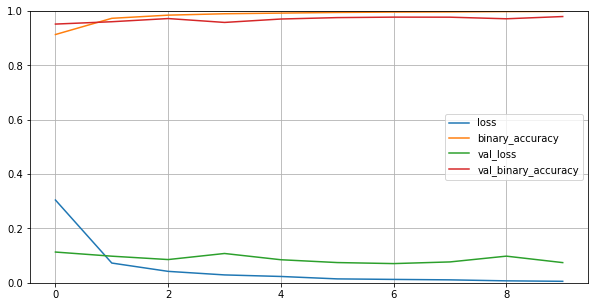

In [17]:
pd.DataFrame(history.history).plot(figsize=(10, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [18]:
# Evaluate the trained model
model.evaluate(test_ds)

753/753 [==============================] - 65s 87ms/step - loss: 0.9488 - binary_accuracy: 0.7692


[0.9488319754600525, 0.7692179679870605]

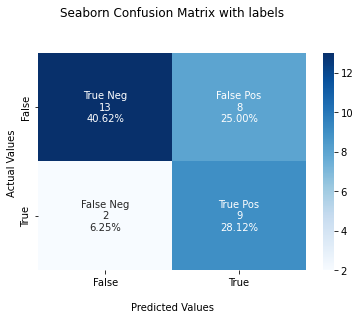

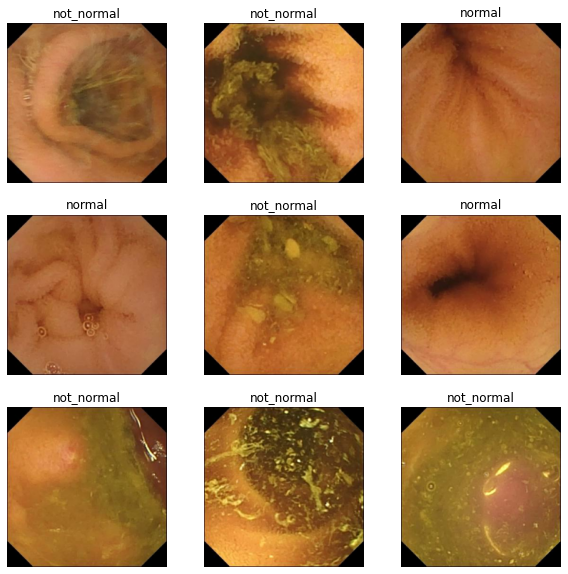

In [19]:
# Plot predictions
test_batches = tf.data.experimental.cardinality(test_ds)
test_dataset = test_ds.take(test_batches // 5)

# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

cm = confusion_matrix(label_batch, predictions.numpy())

plot_cm(cm)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")